# Dataset Description

The DAQUAR dataset, a significant Visual Question Answering (VQA) dataset, was the first of its kind. It comprises 6794 training and 5674 test question-answer pairs, derived from images in the NYU-Depth V2 Dataset, resulting in an average of 9 pairs per image. The dataset is a refined version of the Full DAQUAR Dataset, featuring normalized questions for easier processing by tokenizers. Image IDs, questions, and answers are organized in a tabular (CSV) format, facilitating seamless use for training VQA models.


In [1]:
# %%capture
# #!pip install -U datasets
# !pip install transformers==4.18.0 nltk==3.2.4 numpy==1.21.6 datasets==2.1.0 pandas==1.3.5


In [2]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel, AutoConfig,            
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)
import warnings 
warnings.filterwarnings('ignore')

import nltk
nltk.download('wordnet')
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordne

In [3]:
# cache for Hugging Face Transformers and Datasets.
os.environ['HF_HOME'] = os.path.join(".", "cache")

set_caching_enabled(False)
logging.set_verbosity_error()



In [4]:
#check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))


cuda
Tesla P100-PCIE-16GB


# Load the dataset

In [5]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Read the CSV files directly using pandas
train_df = pd.read_csv("/kaggle/input/vr-image-qna/data_new.csv")
# test_df = pd.read_csv("/kaggle/input/data-eval-sub/eval_final_less(in).csv")
test_df = pd.read_csv("/kaggle/input/vr-image-qna/data_val_new.csv")

# Convert pandas DataFrames to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine into a DatasetDict
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# read answer space from file and split into an array by line
with open("/kaggle/input/vr-image-qna/answer_space_unsampled2.txt") as f:
    answer_space = f.read().splitlines()

def process_examples(examples):
    labels = []
    count1 = 0
    count2 = 0
    for ans in examples['answer']:
        cleaned_answer = ans.replace(" ", "").split(",")[0]
        try:
#             print("try")
#             print(ans)
            count1 += 1
            index = answer_space.index(ans)
            labels.append(index)
        except ValueError:
            count2 += 1
#             print("except")
#             print(ans)
            # Handle unknown cases here, for example:
            labels.append(-1)  # Assign a default label for unknown cases
        
#     print(count1)
#     print(count2)
    return {'label': labels}


dataset = dataset.map(
    process_examples,
    batched=True
)

dataset

  0%|          | 0/111 [00:00<?, ?ba/s]

  0%|          | 0/54 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'imageId', 'questionId', 'questionType', 'answerType', 'kaggle_image_path', 'label'],
        num_rows: 110245
    })
    test: Dataset({
        features: ['question', 'answer', 'imageId', 'questionId', 'questionType', 'answerType', 'kaggle_image_path', 'label'],
        num_rows: 53564
    })
})

### Let's view some data

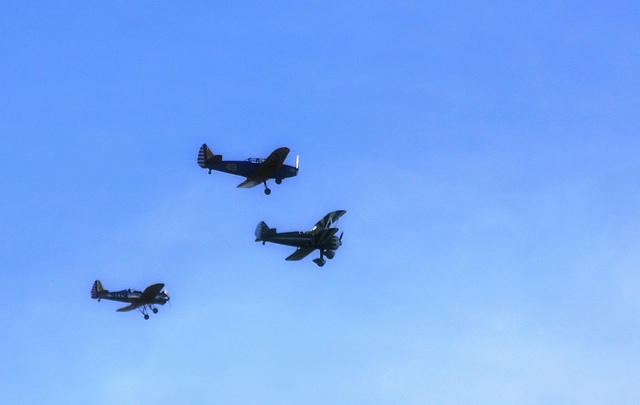

Question:	 What is the name of this squadron?
Answer:		 blue angels (Label: 5524)


'blue angels'

In [6]:
import IPython.display as display

def show_example(train=True, idx=None):
    dataset_type = "train" if train else "test"
    data = dataset[dataset_type]

    if idx is None:
        idx = np.random.randint(len(data))

    image_path =  data[idx]["kaggle_image_path"]
    image = Image.open(image_path)
    display.display(image)

    question = data[idx]["question"]
    answer = data[idx]["answer"]
    label = data[idx]["label"]

    print(f"Question:\t {question}")
    print(f"Answer:\t\t {answer} (Label: {label})")

    return answer
show_example()

## Generate a Multimodal Collator for the Dataset

This collator is designed to be utilized within the Trainer() to seamlessly construct the Dataloader from the dataset, streamlining the input pipeline to the model.

The collator's primary function is to handle both textual (question) and image data. It processes the question text, tokenizing it and generating attention masks. Simultaneously, it featurizes the image, essentially encapsulating its pixel values. These processed inputs are then fed into our multimodal transformer model, facilitating the question-answering process.

In [7]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor
    
    def tokenize_text(self, texts: List[str]) -> Dict[str, torch.Tensor]:
        """
        Tokenize text inputs and return relevant tokenized information.
        """
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }
    
    def preprocess_images(self, images: List[str]):

        processed_images = self.preprocessor(
            images=[Image.open(image_id).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict) -> Dict[str, torch.Tensor]:
        """
        Process raw batch data, tokenize text and extract image features, returning a dictionary
        containing processed inputs and labels.
        """
#         question_batch = raw_batch_dict['question'] if isinstance(raw_batch_dict, dict) else [i['question'] for i in raw_batch_dict]
#         image_id_batch = raw_batch_dict['image_id'] if isinstance(raw_batch_dict, dict) else [i['image_id'] for i in raw_batch_dict]
#         label_batch = raw_batch_dict['label'] if isinstance(raw_batch_dict, dict) else [i['label'] for i in raw_batch_dict]

        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['kaggle_image_path']
                if isinstance(raw_batch_dict, dict) else
                [i['kaggle_image_path'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }


## Defining the Multimodal VQA Model Architecture

Multimodal models can be of various forms to capture information from the text & image modalities, along with some cross-modal interaction as well. Here, we explore "Fusion" Models, that fuse information from the text encoder & image encoder to perform the downstream task (visual question answering).

The text encoder can be a text-based transformer model (like BERT, RoBERTa, etc.) while the image encoder could be an image transformer (like ViT, Deit, BeIT, etc.). After passing the tokenized question through the text-based transformer & the image features through the image transformer, the outputs are concatenated & passed through a fully-connected network with an output having the same dimensions as the answer-space.

Since we model the VQA task as a multi-class classification, it is natural to use the Cross-Entropy Loss as the loss function.

In [8]:
class MultimodalVQAModel(nn.Module):
    def __init__(
        self,
        num_labels: int = len(answer_space),
        intermediate_dim: int = 512,
        pretrained_text_name: str = 'bert-base-uncased',
        pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'
    ):
        """
        Initializes the Multimodal VQA Model.

        Args:
            num_labels (int): Number of labels in the answer space.
            intermediate_dim (int): Dimensionality of the intermediate layer in the fusion module.
            pretrained_text_name (str): Pretrained name for the text encoder.
            pretrained_image_name (str): Pretrained name for the image encoder.
        """
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        
        # Text and image encoders
        
        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)
        
        # Fusion module
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        # Classifier
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()

    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        labels: Optional[torch.LongTensor] = None
    ):
        """
        Forward pass of the model.

        Args:
            input_ids (torch.LongTensor): Tokenized input IDs for text.
            pixel_values (torch.FloatTensor): Pixel values for images.
            attention_mask (Optional[torch.LongTensor]): Attention mask for text.
            token_type_ids (Optional[torch.LongTensor]): Token type IDs for text.
            labels (Optional[torch.LongTensor]): Ground truth labels.

        Returns:
            Dict: Dictionary containing model outputs, including logits. If labels are provided, also includes loss.
        """
        # Encode text with masking
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        
        # Encode images
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        
        # Combine encoded texts and images
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        
        # Make predictions
        logits = self.classifier(fused_output)
        
        out = {"logits": logits}
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out


In [9]:
def create_multimodal_vqa_collator_and_model(text_encoder='bert-base-uncased', image_encoder='google/vit-base-patch16-224-in21k'):
    """
    Creates a Multimodal VQA collator and model.

    Args:
        text_encoder (str): Pretrained name for the text encoder.
        image_encoder (str): Pretrained name for the image encoder.

    Returns:
        Tuple: Multimodal collator and VQA model.
    """
    # Initialize tokenizer and feature extractor
    tokenizer = AutoTokenizer.from_pretrained(text_encoder)
    preprocessor = AutoFeatureExtractor.from_pretrained(image_encoder)
    
    # Create Multimodal Collator
    multimodal_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )

    # Create Multimodal VQA Model
    multimodal_model = MultimodalVQAModel(
        pretrained_text_name=text_encoder,
        pretrained_image_name=image_encoder
    ).to(device)

    return multimodal_collator, multimodal_model


## Performance Metrics in Visual Question Answering: Wu & Palmer Similarity

The Wu & Palmer similarity is a metric designed to measure the semantic similarity between two words or phrases. It does so by considering the positions of the concepts (c1 and c2) in a taxonomy and their relative location to their Least Common Subsumer (LCS(c1, c2)).

In the context of a directed acyclic graph, the Least Common Subsumer is the deepest node that has both considered nodes as descendants. Importantly, each node is considered a descendant of itself.

Wu & Palmer similarity proves effective for single-word answers (the primary focus in our task), but it may not be suitable for phrases or sentences due to its design.

The Natural Language Toolkit (nltk) provides an implementation of the Wu & Palmer similarity score based on the WordNet taxonomy. This implementation to align with the definition of Wu & Palmer similarity as specified in the DAQUAR dataset.

In [10]:
def wup_measure(a, b, similarity_threshold=0.925):
    """
    Computes the Wu-Palmer similarity score between two words or phrases.

    Args:
        a (str): First word or phrase.
        b (str): Second word or phrase.
        similarity_threshold (float): Threshold for similarity to consider semantic fields.

    Returns:
        float: Wu-Palmer similarity score.
    """
    def get_semantic_field(word):
        """
        Retrieves the semantic field for a word.

        Args:
            word (str): Word to retrieve the semantic field for.

        Returns:
            Tuple: Tuple containing the semantic field and weight.
        """
        weight = 1.0
        semantic_field = wordnet.synsets(word, pos=wordnet.NOUN)
        return semantic_field, weight

    def get_stem_word(word):
        """
        Processes words in the form 'word\d+:wordid' by returning the word and downweighting.

        Args:
            word (str): Word to process.

        Returns:
            Tuple: Tuple containing the processed word and weight.
        """
        weight = 1.0
        return word, weight

    global_weight = 1.0

    # Get stem words and weights
    a, global_weight_a = get_stem_word(a)
    b, global_weight_b = get_stem_word(b)
    global_weight = min(global_weight_a, global_weight_b)

    # Check if words are the same
    if a == b:
        return 1.0 * global_weight

    # Check for empty strings
    if a == "" or b == "":
        return 0

    # Get semantic fields and weights
    interp_a, weight_a = get_semantic_field(a)
    interp_b, weight_b = get_semantic_field(b)

    # Check for empty semantic fields
    if interp_a == [] or interp_b == []:
        return 0

    # Find the most optimistic interpretation
    global_max = 0.0
    for x in interp_a:
        for y in interp_b:
            local_score = x.wup_similarity(y)
            if local_score > global_max:
                global_max = local_score

    # Use semantic fields and downweight unless the score is high (indicating synonyms)
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score = global_max * weight_a * weight_b * interp_weight * global_weight
    return final_score

def batch_wup_measure(labels, preds):
    """
    Computes the average Wu-Palmer similarity score for a batch of predicted and ground truth labels.

    Args:
        labels (List): List of ground truth labels.
        preds (List): List of predicted labels.

    Returns:
        float: Average Wu-Palmer similarity score for the batch.
    """
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)


In [11]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['8:40', 'half windsor', 'stop for pedestrians', '035', 'turning']
['scooter', "kern's", 'because of light', 'trip happened', 'arts']
Predictions vs Labels:  0.015000000000000003
Labels vs Labels:  1.0


In [12]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    """
    Computes evaluation metrics for a given set of logits and labels.

    Args:
        eval_tuple (Tuple): Tuple containing logits and corresponding ground truth labels.

    Returns:
        Dict: Dictionary of computed metrics, including WUP similarity, accuracy, and F1 score.
    """
    logits, labels = eval_tuple

    # Calculate predictions
    preds = logits.argmax(axis=-1)

    # Compute metrics
    metrics = {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

    return metrics


# Train the model and evaluate

In [13]:
# Define training arguments for the model

args = TrainingArguments(
    output_dir="/kaggle/working/checkpoint/",            # Output directory for checkpoints and logs=
    seed=12345,                         # Seed for reproducibility
    evaluation_strategy="steps",        # Evaluation strategy: "steps" or "epoch"
    eval_steps=100,                     # Evaluate every 100 steps
    logging_strategy="steps",           # Logging strategy: "steps" or "epoch"
    logging_steps=100,                  # Log every 100 steps
    save_strategy="steps",              # Saving strategy: "steps" or "epoch"
    save_steps=100,                     # Save every 100 steps
    save_total_limit=3,                 # Save only the last 3 checkpoints at any given time during training 
    metric_for_best_model='wups',       # Metric used for determining the best model
    per_device_train_batch_size=64,     # Batch size per GPU for training
    per_device_eval_batch_size=64,      # Batch size per GPU for evaluation
    remove_unused_columns=False,        # Whether to remove unused columns in the dataset
    num_train_epochs=5,                 # Number of training epochs
    fp16=True,                          # Enable mixed precision training (float16)
    dataloader_num_workers=8,           # Number of workers for data loading
    load_best_model_at_end=True,        # Whether to load the best model at the end of training
)
    



In [14]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb2")
os.environ["WANDB_API_KEY"] = wandb_key
wandb.login(key = wandb_key)
!wandb status

wandb: Currently logged in as: achintyaharsha03 (achiorg). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Current Settings
{
  "_extra_http_headers": null,
  "_proxies": null,
  "api_key": null,
  "base_url": "https://api.wandb.ai",
  "entity": null,
  "git_remote": "origin",
  "ignore_globs": [],
  "project": null,
  "root_dir": null,
  "section": "default"
}


In [15]:
def create_and_train_model(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    """
    Creates a Multimodal VQA collator and model, and trains the model using the provided dataset and training arguments.

    Args:
        dataset (Dict): Dictionary containing 'train' and 'test' datasets.
        args (TrainingArguments): Training arguments for the model.
        text_model (str): Pretrained name for the text encoder.
        image_model (str): Pretrained name for the image encoder.
        multimodal_model (str): Name for the multimodal model.

    Returns:
        Tuple: Collator, model, training metrics, and evaluation metrics.
    """
    # Create Multimodal Collator and Model
    collator, model = create_multimodal_vqa_collator_and_model(text_model, image_model)
    
    # Create a copy of arguments and set the output directory
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("/kaggle/working/checkpoint/", multimodal_model)
    print(multi_args.output_dir)
    # Create Trainer for Multimodal Model
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )
    
    # Train and evaluate for metrics
#     train_multi_metrics = multi_trainer.train()
#     eval_multi_metrics = multi_trainer.evaluate()
    train_multi_metrics = []
    eval_multi_metrics = []
    
    return collator, model, train_multi_metrics, eval_multi_metrics, multi_trainer


In [16]:
collator, model, train_multi_metrics, eval_multi_metrics, trainer = create_and_train_model(dataset, args)


/kaggle/working/checkpoint/bert_vit


In [17]:
# eval_multi_metrics

In [18]:
from safetensors.torch import load_file as load_safetensors_file
model = MultimodalVQAModel()
state_dict = load_safetensors_file("/kaggle/input/model1/model.safetensors")

model.load_state_dict(state_dict)
model.to(device) 


MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [19]:
import random

num_of_imgs = 50

# Randomly sample 10 indices from the test dataset
random_sample_indices = random.sample(range(len(dataset["test"])), k=num_of_imgs)

# Sample data for manual testing
sample = collator([dataset["test"][index] for index in random_sample_indices])

# Extract input components from the sample for manual testing
input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)


In [20]:
# Set the model to evaluation mode
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)


In [21]:
# Get predictions from the model output
predictions = output["logits"].argmax(axis=-1).cpu().numpy()
predictions


array([  199, 29158, 17798,  1070, 29158, 28391, 29158, 29158, 29158,
       17798, 22293,  5508, 28834, 29158,  4377,  6098, 17798,  1070,
        4643,  3740, 29158, 29158,  5508, 25190,  1070, 29158, 25622,
       29158, 24795, 29158, 29158, 17798, 17798, 28690, 29158, 18347,
       17798,  5508, 22545, 23387, 28391,  6098, 21865, 22293, 24795,
       29158, 29158, 11222, 17798, 17798])

 15



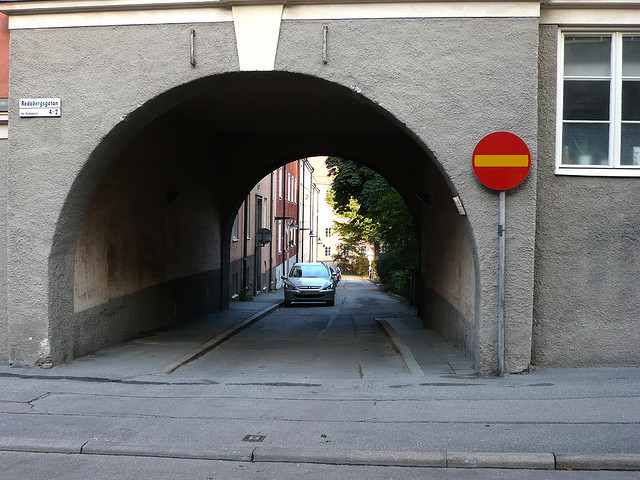

Question:	 Can you turn right or left in the tunnel?
Answer:		 no (Label: 17798)
Predicted Answer:	 broccoli
Similarity: 0.1


 23



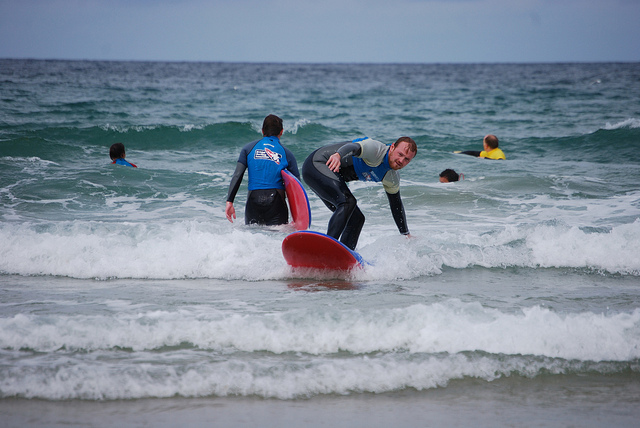

Question:	 Are any of these people wearing a wetsuit?
Answer:		 yes (Label: 29158)
Predicted Answer:	 surfing
Similarity: 0.2


 40



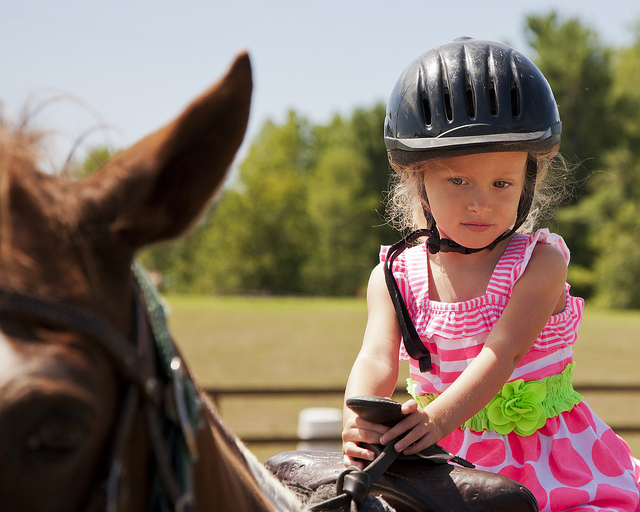

Question:	 What color is the horse?
Answer:		 brown (Label: 6174)
Predicted Answer:	 oak
Similarity: 0.23529411764705882


 45



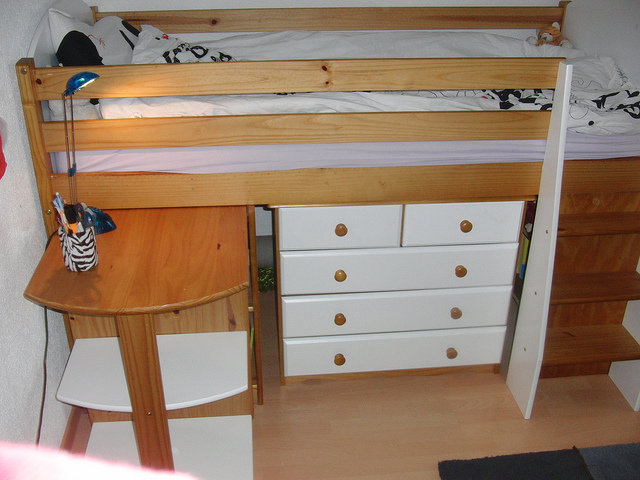

Question:	 Is this a child room?
Answer:		 yes (Label: 29158)
Predicted Answer:	 yes
Similarity: 1.0


 49



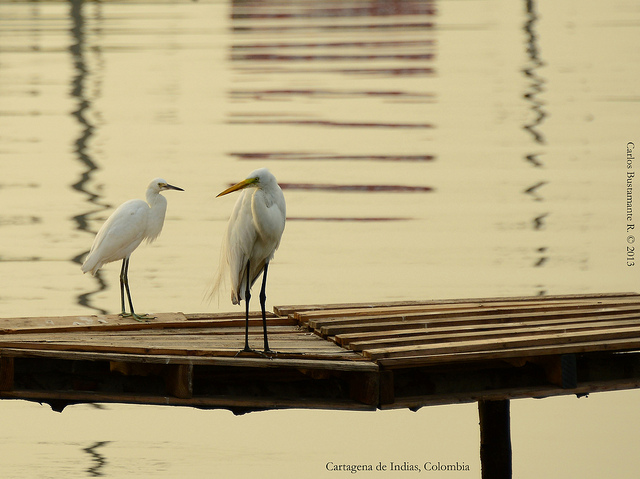

Question:	 Are the birds legs touching the water?
Answer:		 no (Label: 17798)
Predicted Answer:	 no
Similarity: 1.0




In [28]:
from nltk.corpus import wordnet

def similarity(a, b):
    # Split words if it is a list and remove extra spaces
    words_a = [w.strip() for w in a.split(',')]
    words_b = [w.strip() for w in b.split(',')]

    # Split words if connected by underscore _
    a = [w_ for word in words_a for w_ in word.split('_')]
    b = [w_ for word in words_b for w_ in word.split('_')]

    res = 0
    n = 0

    # Calculate score and take average
    for i in a:
        synsets_i = wordnet.synsets(i)
        if synsets_i:
            s1 = synsets_i[0]
            for j in b:
                synsets_j = wordnet.synsets(j)
                if synsets_j:
                    s2 = synsets_j[0]
                    sim = s1.wup_similarity(s2)
                    if sim:
                        res += sim
                    n += 1

    return res / n if n != 0 else 0

# Show predictions for a range of examples
li = [15, 23, 40, 45, 49]
for i in li:
    print(f"{i : }\n=========================================================\n")
    real_answer = show_example(train=False, idx=i)
    predicted_answer = answer_space[predictions[i]]
    print("Predicted Answer:\t", predicted_answer)
    print(f"Similarity: {similarity(real_answer, predicted_answer)}")
    print("\n=========================================================\n")
